# Import Library such as pandas, numpy, etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import os
import zipfile
import shutil
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
plt.style.use('ggplot')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import load_img, img_to_array
from PIL import Image
import random
import shutil
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# Setting dataset directory

In [2]:
dir = './Redata/'

data_dir_list = os.listdir(dir)
print('Folders :', os.listdir(dir))
classes = sorted(os.listdir(dir))
file_count = len(classes)
print(len(classes), 'class', classes)

Folders : ['Acral Lentiginous Melanoma', 'Beaus Line', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Muehrckes Lines', 'Onychogryphosis', 'Pitting', 'Terry-s Nail']
10 class ['Acral Lentiginous Melanoma', 'Beaus Line', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Muehrckes Lines', 'Onychogryphosis', 'Pitting', 'Terry-s Nail']


In [3]:
base_dir = './dataset'
if not os.path.exists(base_dir):
        os.makedirs(base_dir)

In [4]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
valid_dir = os.path.join(base_dir, 'valid')
if not os.path.exists(valid_dir):
    os.mkdir(valid_dir)

for i in classes:
    train_class_dir = os.path.join(train_dir, i)
    if not os.path.exists(train_class_dir):
        os.mkdir(train_class_dir)
    valid_class_dir = os.path.join(valid_dir, i)
    if not os.path.exists(valid_class_dir):
        os.mkdir(valid_class_dir)

In [5]:
print(classes)

['Acral Lentiginous Melanoma', 'Beaus Line', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Muehrckes Lines', 'Onychogryphosis', 'Pitting', 'Terry-s Nail']


# Splitting data

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        shutil.copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        shutil.copyfile(SOURCE + file_name, TESTING + file_name)

In [7]:
split_size = .8

source_dir = './Redata/'
train_dir = './dataset/train/'
valid_dir = './dataset/valid/'

for i in classes:
  class_source_dir = f'./Redata/{i}/'
  class_train_dir = f'./dataset/train/{i}/'
  class_valid_dir = f'./dataset/valid/{i}/'
  split_data(class_source_dir, class_train_dir, class_valid_dir, split_size)

In [8]:
for i in classes:
    print('Training {} images are: '.format(i)+str(len(os.listdir(train_dir + '/' + i + '/'))))

Training Acral Lentiginous Melanoma images are: 350
Training Beaus Line images are: 349
Training Blue Finger images are: 350
Training Clubbing images are: 348
Training Healthy Nail images are: 349
Training Koilonychia images are: 349
Training Muehrckes Lines images are: 350
Training Onychogryphosis images are: 350
Training Pitting images are: 350
Training Terry-s Nail images are: 349


In [9]:
for i in classes:
    print('Valid {} images are: '.format(i)+str(len(os.listdir(valid_dir + '/' + i + '/'))))

Valid Acral Lentiginous Melanoma images are: 206
Valid Beaus Line images are: 207
Valid Blue Finger images are: 202
Valid Clubbing images are: 198
Valid Healthy Nail images are: 213
Valid Koilonychia images are: 214
Valid Muehrckes Lines images are: 205
Valid Onychogryphosis images are: 208
Valid Pitting images are: 206
Valid Terry-s Nail images are: 199


# Modelling

In [10]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  
  tf.random.set_seed(42)
  
  train_datagen = ImageDataGenerator(rescale = 1./255.)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      seed = 42)

  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size= 64,
                                                                class_mode='categorical',
                                                                target_size=(224, 224),
                                                                seed = 42)
  return train_generator, validation_generator

In [11]:
TRAINING_DIR = "./dataset/train/"
VALIDATION_DIR = "./dataset/valid/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 3494 images belonging to 10 classes.
Found 2058 images belonging to 10 classes.


In [12]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the method that checks the accuracy at the end of each epoch
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.90: # @KEEP
                print("\nReached 90% accuracy so cancelling training!") 
                
                # Stop training once the above condition is met
                self.model.stop_training = True

In [13]:
def create_model():
    base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer= tf.keras.optimizers.RMSprop(),
                loss= 'categorical_crossentropy',
                metrics=['accuracy']) 
    return model

In [14]:
def lr_scheduler(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)

In [15]:
model = create_model()
callbacks = myCallback()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
lr_callback = LearningRateScheduler(lr_scheduler)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 49,257,738
Trainable params: 25,692,938
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
'''from numba import cuda
cuda.select_device(0)
cuda.close()'''

'from numba import cuda\ncuda.select_device(0)\ncuda.close()'

In [17]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=30,
                    callbacks=[lr_callback, callback])

Epoch 1/30
55/55 [==============================] - 26s 372ms/step - loss: 23.4766 - accuracy: 0.3746 - val_loss: 2.5410 - val_accuracy: 0.5811 - lr: 0.0010
Epoch 2/30
55/55 [==============================] - 8s 137ms/step - loss: 2.4878 - accuracy: 0.6365 - val_loss: 1.1935 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 3/30
55/55 [==============================] - 8s 137ms/step - loss: 1.2862 - accuracy: 0.7730 - val_loss: 0.3640 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 4/30
55/55 [==============================] - 8s 137ms/step - loss: 0.5841 - accuracy: 0.8718 - val_loss: 0.0886 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 5/30
55/55 [==============================] - 8s 138ms/step - loss: 0.4400 - accuracy: 0.9164 - val_loss: 0.2705 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 6/30
55/55 [==============================] - 8s 138ms/step - loss: 0.2280 - accuracy: 0.9402 - val_loss: 0.3307 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 7/30
55/55 [==============================] - 8s 137ms/step - 

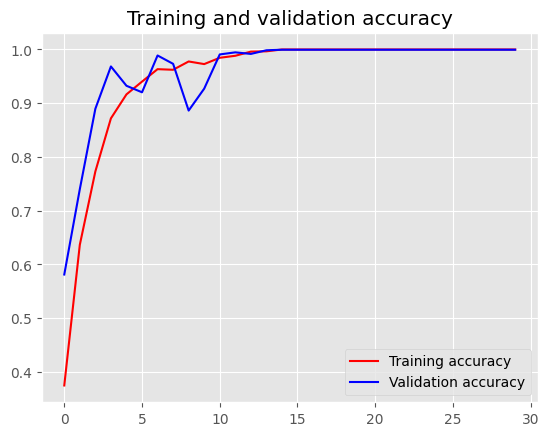

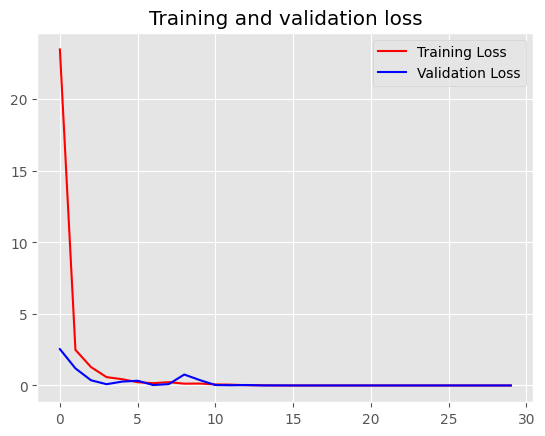

In [18]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()